# Python analysis

[...]

The size of the roaring bitmaps are given by the arguments `--size1` and `--size2`, their densities by the arguments `--density1` and `--density2`. Sizes are integers, densities are floats.
These arguments can be a single value (e.g. `--size1 27`), a list of values (e.g. `--size1 32,64,128,256`) or a range of values (e.g. `--size1 1:1000`).
The value actually used for each experiment is sampled randomly and uniformly in the given list (resp. range).

The argument `--size2` (resp. `--density2`) can be omitted. In this case, the random value used for each experiment will be exactly the same than the one used for the first size (resp. the first density). In this case, the two sizes (resp. densities) are therefore not independent anymore.

In [1]:
library(ggplot2)

The following results have been obtained with the command:
```bash
./scripts/size_density_runner.py\
    --size1 1:10000000 --size2 1:10000000\
    --density1 0.01,0.04,0.1,0.5,0.999\
    -n 434 results/python_results.csv
```

Size of the two roaring bitmaps are sampled randomly and uniformly in [0, 10^7], a density is sampled randomly and uniformly in {0.01, 0.04, 0.1, 0.5, 0.999} (same density for the two bitmaps).

In [2]:
all_times = read.csv("results/python_results.csv")
all_times$density1 <- factor(all_times$density1)
all_times$class <- factor(all_times$class)
all_times$size_sum <- apply(all_times[,c('size1','size2')], 1, function(y) sum(y['size1'],y['size2'])) # can also take the max

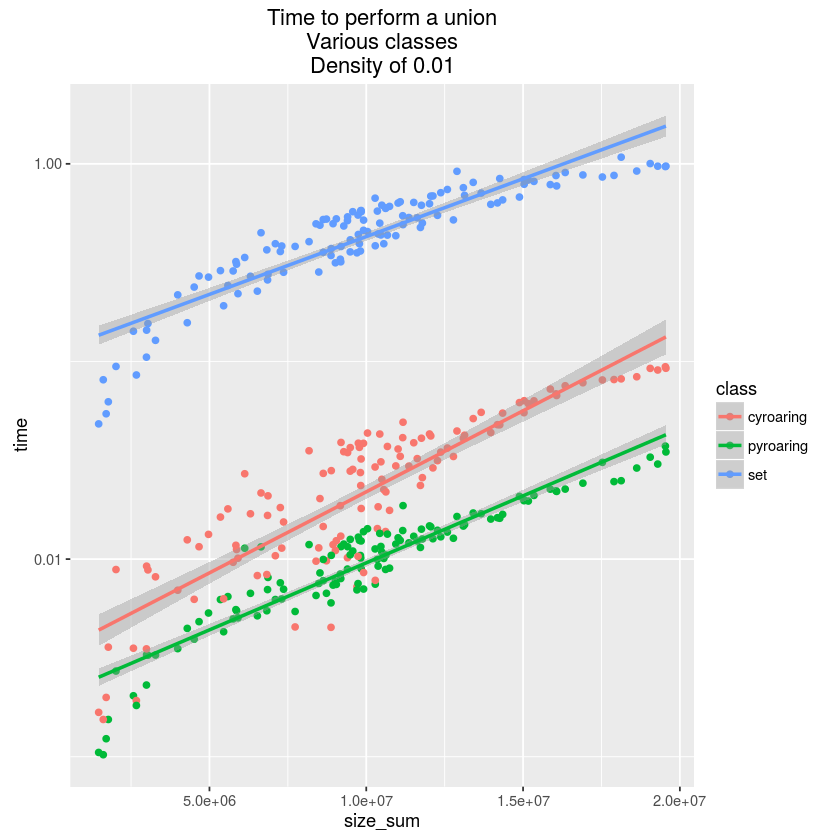

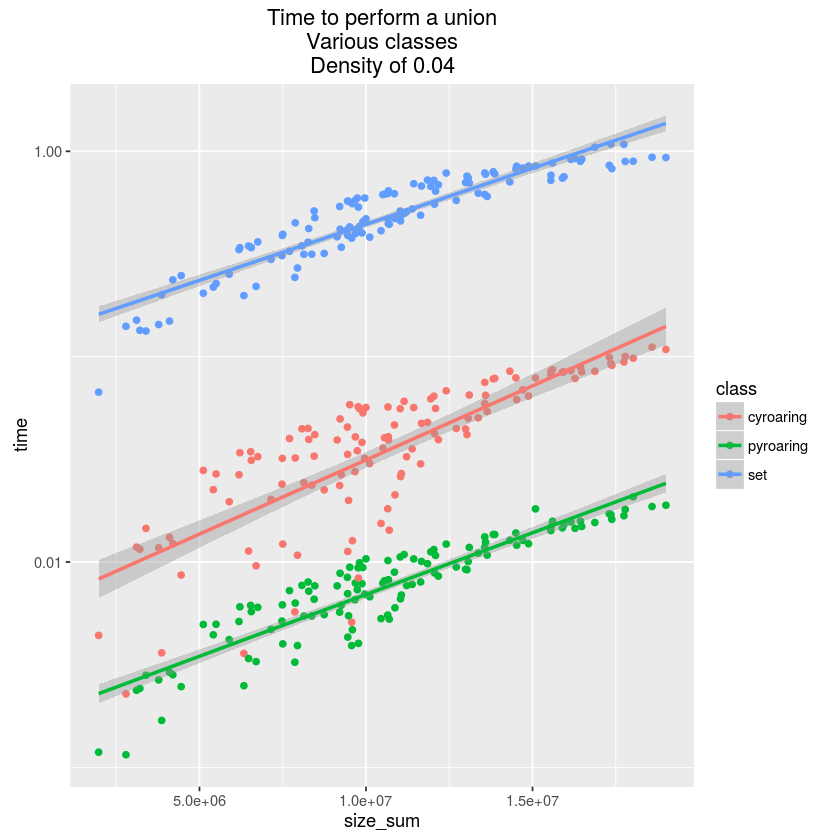

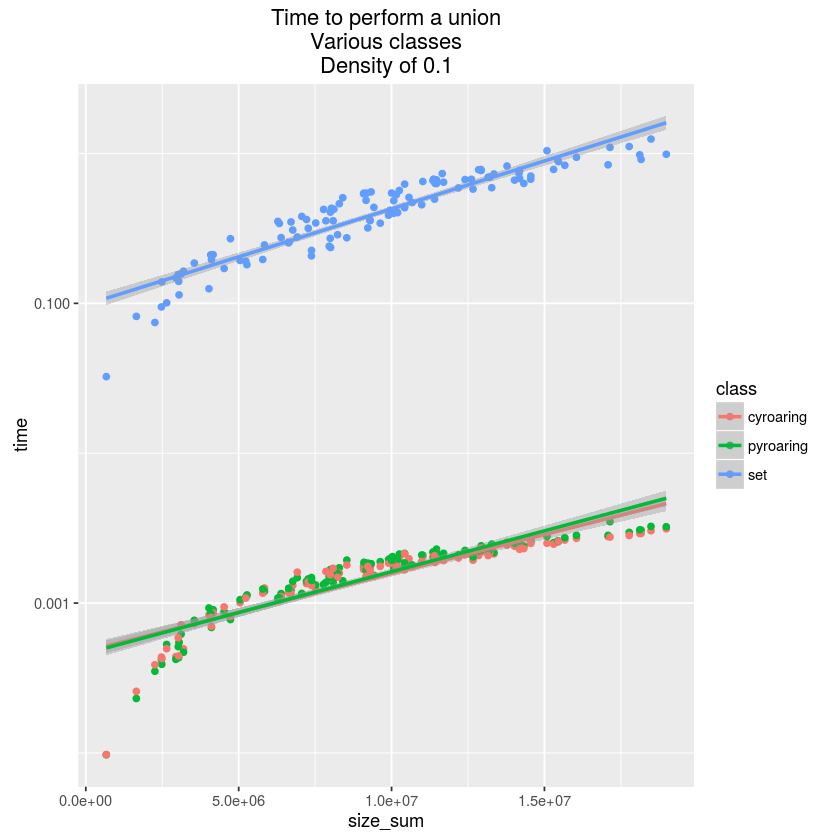

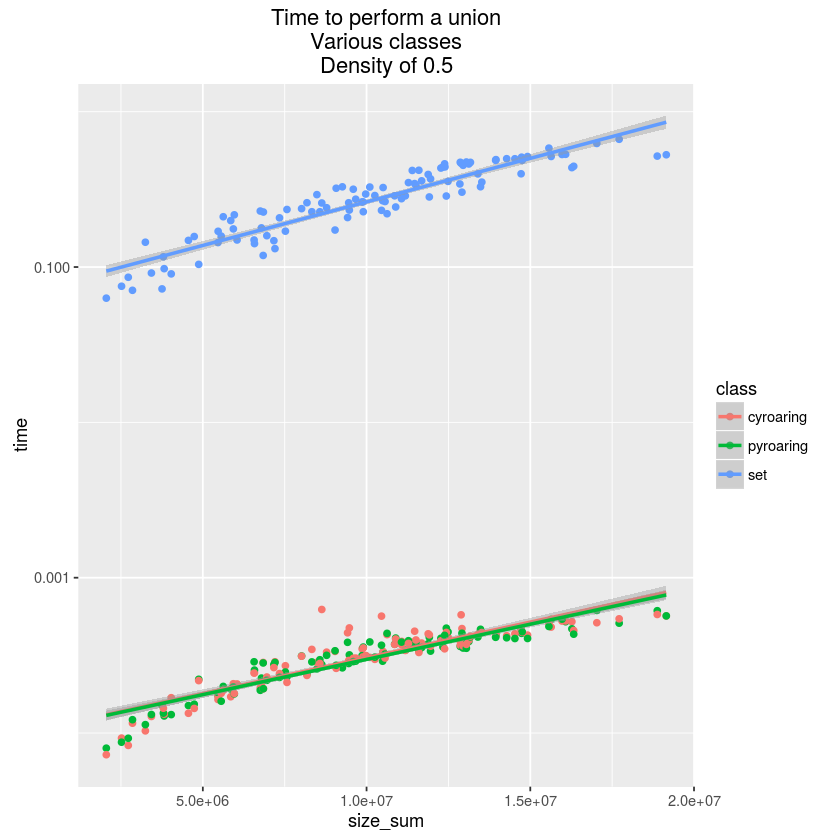

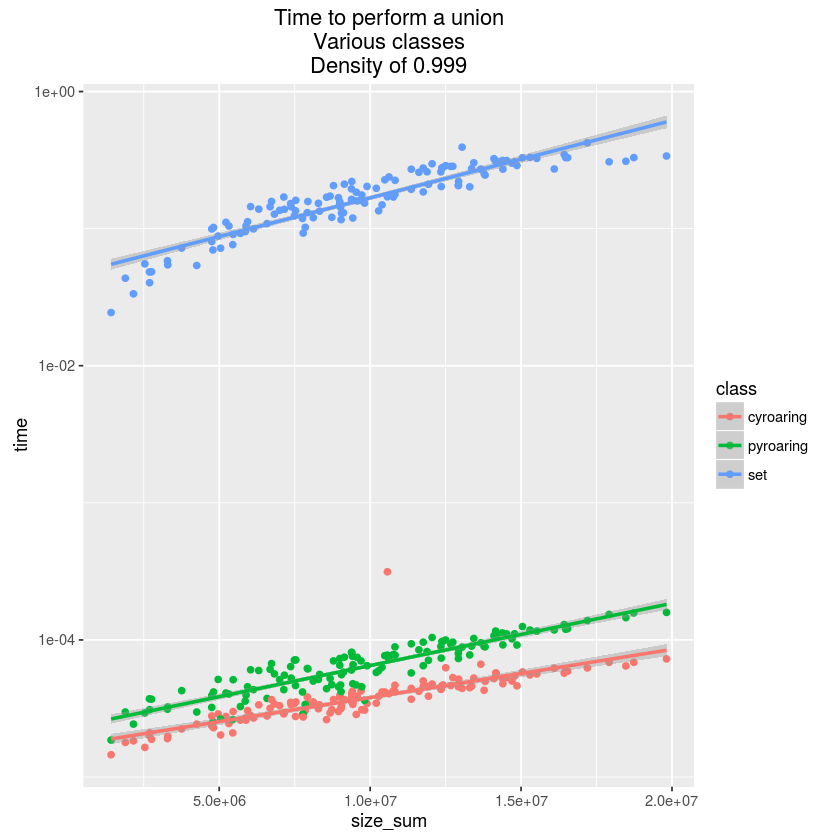

In [3]:
for(density in sort(unique(all_times[,'density1']))) {
    title <- paste("Time to perform a union\nVarious classes\nDensity of", density)
    print(ggplot(all_times[all_times['density1'] == density,], aes(x=size_sum, y=time, group=class, colour=class))+
                geom_point() + geom_smooth(method=lm) +
                ggtitle(title) +
                scale_y_log10()
    )
}

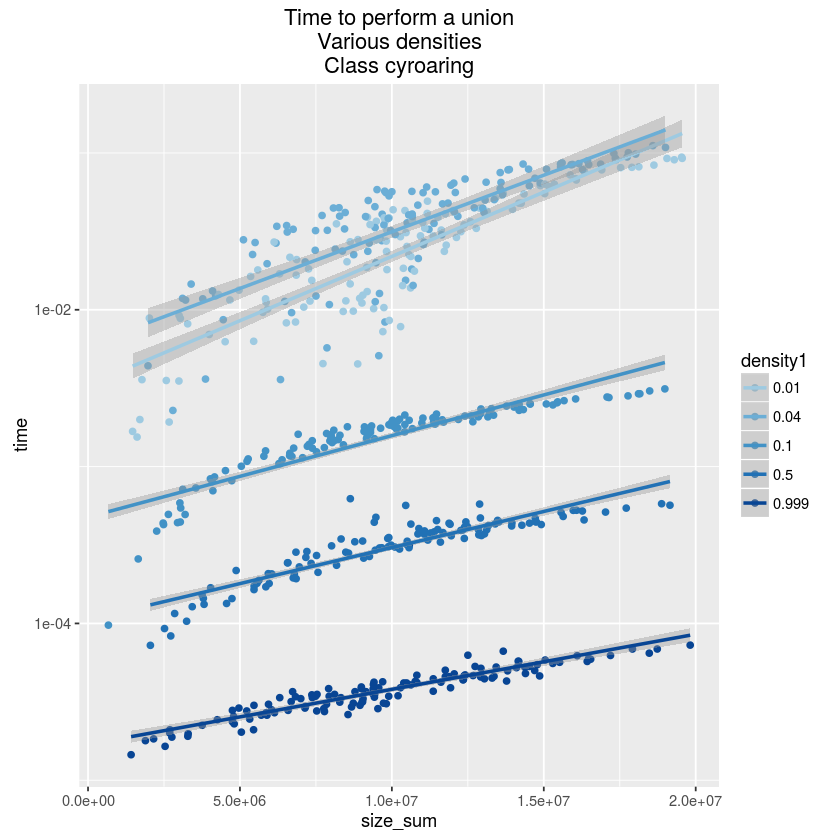

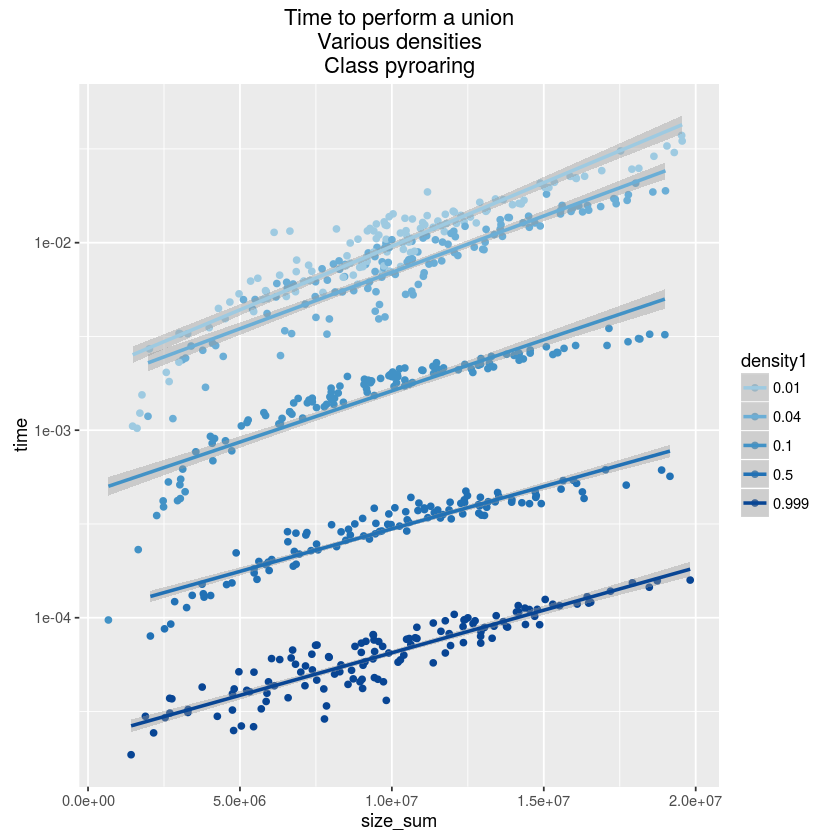

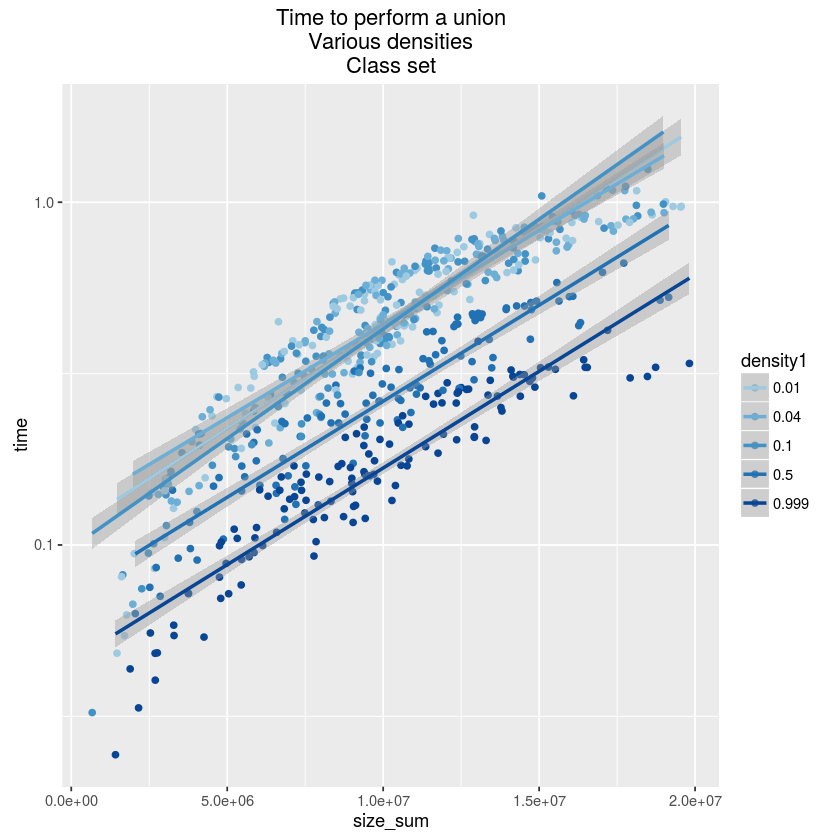

In [4]:
library(RColorBrewer)
my_colors = brewer.pal(n = 7, "Blues")[3:7] # we exclude the lightest colors


for(class in sort(unique(all_times[,'class']))) {
    title <- paste("Time to perform a union\nVarious densities\nClass", class)
    print(ggplot(all_times[all_times['class'] == class,], aes(x=size_sum, y=time, group=density1, colour=density1))+
            geom_point() + geom_smooth(method=lm) +
            ggtitle(title) +
            scale_colour_manual(values=my_colors) +
            scale_y_log10()
    )
}

In [5]:
for(density in sort(unique(all_times[,'density1']))) {
    print(paste('density =', density))
    print(lm(time~size_sum, data=all_times[all_times['density1'] == density & all_times['class'] == 'pyroaring',])$coefficients)
}


[1] "density = 0.01"
  (Intercept)      size_sum 
-4.219559e-03  1.599490e-09 
[1] "density = 0.04"
  (Intercept)      size_sum 
-2.581541e-03  1.071203e-09 
[1] "density = 0.1"
 (Intercept)     size_sum 
1.138757e-04 1.703118e-10 
[1] "density = 0.5"
 (Intercept)     size_sum 
3.146755e-05 2.921997e-11 
[1] "density = 0.999"
 (Intercept)     size_sum 
4.779244e-07 7.145504e-12 


We see here that the densities of the two roaring bitmaps change a lot the performances. Low densities like 0.01 or 0.04 yield to a union two orders of magnitude slower than high densities like 0.5 or 0.999.

We recall that the transition from array container to bitset container happens when the container holds 2^12 elements. The maximum number of elements is 2^16, so this corresponds to a density of 2^-4 = 0.0625. Therefore, in our experiments, the two lowest densities are more likely to have array (and maybe run) containers whereas the other densities are more likely to have bitset (and maybe run) containers.

Also, bitmaps with lower densities will have a larger number of containers, with less elements per containers.

The overall performances are very good: 0.01ns to 1ns per element.

## Conclusion

Similarly to the preliminary analysis, our first results were not good. Examination of the plots has shown that the variance was not constant, i.e. the results were heteroscedastic.

We found out that this came from the usage of copy on write (COW), which occasionally gave very optimistic results. We therefore disabled this option, to have better results that match more closely the “true performances”. Indeed, one can argue that for performance evaluation, COW is somehow “cheating”, since one may have to pay the cost of the copy later if the result of the union or one of the operands is modified.

Finally, we plotted the time required to take the union as a function of the sum of the bitmaps' sizes, for various densities. This has shown the high performance of this operation as well as the great impact of the densities.